# IMNN vs regression networks

In this example we'll compare using an IMNN and training a neural network to do regression. Specifically we'll get an IMNN to summarise the slopes of noisy lines, and regress a network using mean squared error to the values of these slopes. The model is
$$y=mx+\epsilon$$
where $\epsilon\leftarrow N(0, 1)$ and $x\in[0,10]$. We're not particularly aiming to show that the IMNN is better, although in principle, the direct targeting of the effects of the slope rather than just seeing many realisations of slopes should allow the IMNN to extract more information, at least at the fiducial parameter values.

In [1]:
import jax
import jax.numpy as np
import imnn
import imnn.lfi
import tensorflow_probability
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from functools import partial
from jax.example_libraries import stax, optimizers
tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)

We'll first make our simulator

In [2]:
input_shape = (100,)
n_params = 1
n_summaries = n_params

x = np.linspace(0, 10, input_shape[0]).astype(np.float32)

def simulator(key, m, squeeze=True):
    y = (m * x[np.newaxis, :] 
         + jax.random.normal(key, shape=(m.shape[0],) + x.shape))
    if squeeze:
        y = np.squeeze(y)
    return y

And we'll set up the prior distribution for the possible values of $m$ (just a uniform between $-5<m<5$)

In [3]:
prior = tfp.distributions.Independent(
    tfp.distributions.Uniform(low=[-5.], high=[5.]),
    reinterpreted_batch_ndims=1)
prior.low = np.array([-5.])
prior.high = np.array([5.])

For example, some realisations of this data looks like

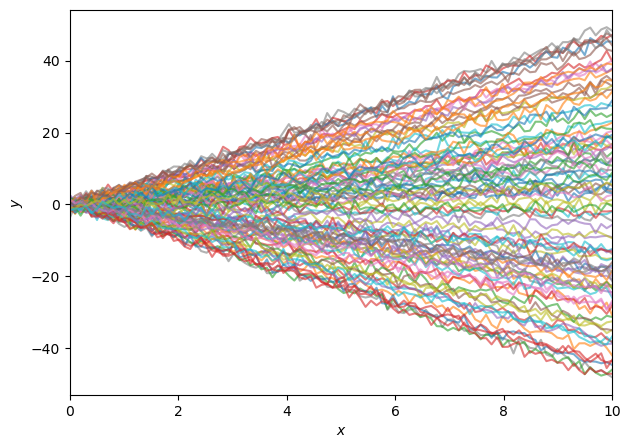

In [4]:
fig = plt.figure(figsize=(7, 5))
plt.xlabel("$x$")
plt.xlim([0, 10])
plt.ylabel("$y$");
plt.tick_params(axis="both")
rng, simulator_key, parameter_key = jax.random.split(rng, num=3)
simulator_keys = np.array(jax.random.split(simulator_key, num=100))
parameter_keys = np.array(jax.random.split(parameter_key, num=100))
plt.plot(
    x, 
    jax.vmap(simulator)(
        simulator_keys, 
        jax.vmap(
            lambda key:prior.sample(seed=key))(
            parameter_keys)).T, 
    alpha=0.6);

We're going to use a model built with stax, and use exactly the same model (with the same initialisation) for both the IMNN and the mse regression network

In [5]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries),
)
optimiser = optimizers.adam(step_size=1e-3)

The IMNN does the initialisation by just providing a key on the class instantiation, and we'll manually initialise the mse network in the same way. To make a better comparison we're going to ensure that the same number of simulations are seen by both networks. Note that for the IMNN, these will all be simulations at the same parameter value (with their gradients calculated automatically) whilst with the regression network, the simulations will be made with slopes drawn randomly from the prior. To do this we're going to set the number of simulations for the IMNN to be ``n_s=1000`` and for no real reason, we'll choose the fiducial parameter value to be $m^\textrm{fid}=4$.

In [6]:
n_s = 1000
n_d = n_s
m_fid = np.array([4.])

Now to initialise the networks we'll get a random number generator

In [7]:
rng, key = jax.random.split(rng)

And pass the simulator to the IMNN decision function

In [8]:
IMNN = imnn.IMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=m_fid, model=model, 
    optimiser=optimiser, key_or_state=key,
    simulator=lambda key, m: simulator(key, m))

`simulator` provided, using SimulatorIMNN


We'll then initialise the model for the regression network with the same key.

In [9]:
mse_output, mse_w = model[0](key, input_shape)
mse_state = optimiser[0](mse_w)

To see that they are the same we can pass the same piece of data through the networks and look at the value of the result

In [10]:
rng, key = jax.random.split(rng)
print("IMNN output = " +
      f"{IMNN.model(IMNN.w, simulator(key, np.array([1.])))}")
print("regression network output = " +
      f"{model[1](mse_w, simulator(key, np.array([1.])))}")

IMNN output = [-1.4816211]
regression network output = [-1.4816211]


We'll train the IMNN first so we know how many epochs to run the training of the regression network for, since the IMNN will stop according to early stopping on the amount of information extracted

0it [00:00, ?it/s]

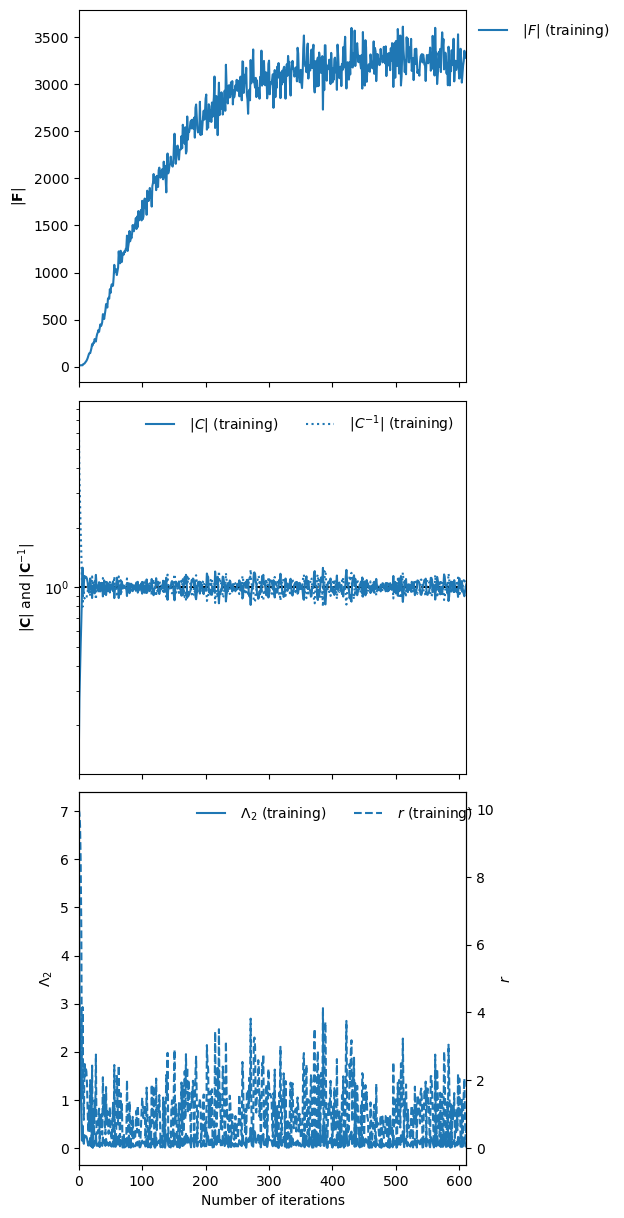

In [11]:
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=1, best=False)
IMNN.plot();

It took 611 iterations of training until early stopping finished the fitting of the IMNN, so we will run the regression for the same amount of time, training it with 611000 different simulations. We'll actually run the simulations on the fly, and we'll make fixed validation set to compare.

In [12]:
rng, key = jax.random.split(rng)
validation_m = prior.sample(100, seed=key)

rng, *keys = jax.random.split(rng, num=101)
validation_y = jax.vmap(simulator)(
    np.array(keys), validation_m)

The loss function to optimise will take a random number and the current network parameters, and generate ``n_s`` $m$ values and generate simulations at each of these values and then calculate the mean squared difference between the output of the network with the simulation as an input and the value of $m$ just drawn. We'll also get the value and the gradient of this function.

In [13]:
@jax.jit
def mse(w, m, y):
    return np.mean((model[1](w, y) - m)**2.)

@partial(jax.value_and_grad, argnums=1)
@jax.jit
def g_mse(rng, w):
    m_key, y_key = jax.random.split(rng)
    m = prior.sample(n_s, seed=m_key)
    y_keys = np.array(jax.random.split(y_key, num=n_s))
    y = jax.vmap(simulator)(y_keys, m)
    return mse(w, m, y)

Now we'll run the training

In [14]:
mse_loss = np.zeros((611, 2))
bar = tqdm.trange(611)
for i in bar:
    w = optimiser[2](mse_state)
    rng, key = jax.random.split(rng)
    l, g = g_mse(key, w)
    mse_state = optimiser[1](i, g, mse_state)
    w = optimiser[2](mse_state)
    mse_loss = mse_loss.at[i].set(l, mse(w, validation_m, validation_y)) 
    bar.set_postfix(loss=mse_loss[i])

  0%|          | 0/611 [00:00<?, ?it/s]

/tmp/ipykernel_13216/3048512137.py:9: FutureWarning: jnp.ndarray.at[...].set: Passing 'indices_are_sorted' by position is deprecated. Pass by keyword instead
  mse_loss = mse_loss.at[i].set(l, mse(w, validation_m, validation_y))


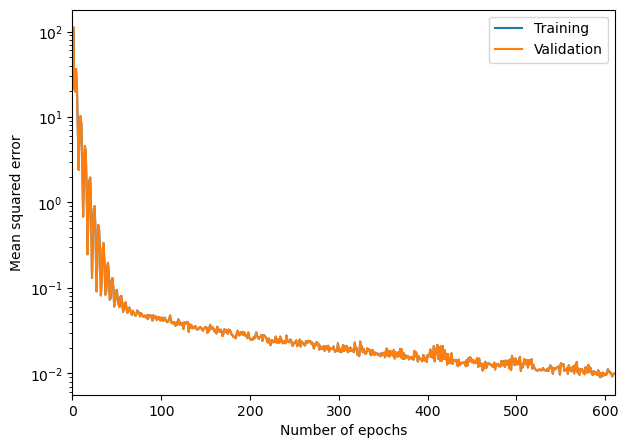

In [15]:
fig = plt.figure(figsize=(7, 5))
plt.semilogy(mse_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Mean squared error")
plt.xlim([0, 611])
plt.legend(["Training", "Validation"]);

We can also check how well the regression network works with a test set

In [16]:
rng, key = jax.random.split(rng)
test_m = prior.sample(100, seed=key)

rng, *keys = jax.random.split(rng, num=101)
test_y = jax.vmap(simulator)(
    np.array(keys), test_m)

mse_m = model[1](w, test_y)

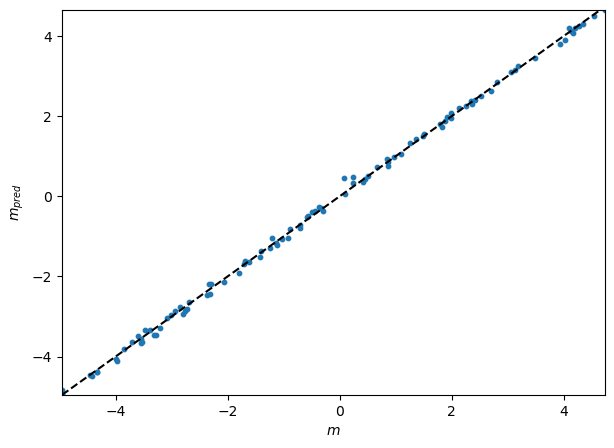

In [17]:
fig = plt.figure(figsize=(7, 5))
plt.scatter(test_m, mse_m, s=10)
plt.plot(
    [test_m.min(), test_m.max()], 
    [test_m.min(), test_m.max()], 
    linestyle="dashed", 
    color="black")
plt.xlim([test_m.min(), test_m.max()])
plt.ylim([mse_m.min(), mse_m.max()])
plt.xlabel("$m$")
plt.ylabel("$m_{pred}$");

### Inference

Now we can use both of these networks to do some inference. We're going to try and infer the value of the slopes for three lines, one generated at a value at the fiducial, one not far from the fiducial and one very far, i.e. $m^\textrm{target}=\{4, 1, -4\}$.

In [18]:
rng, *keys = jax.random.split(rng, num=4)
target_m = np.expand_dims(np.array([4., 1., -4.]), 1)
target_data = jax.vmap(simulator)(np.array(keys), target_m)

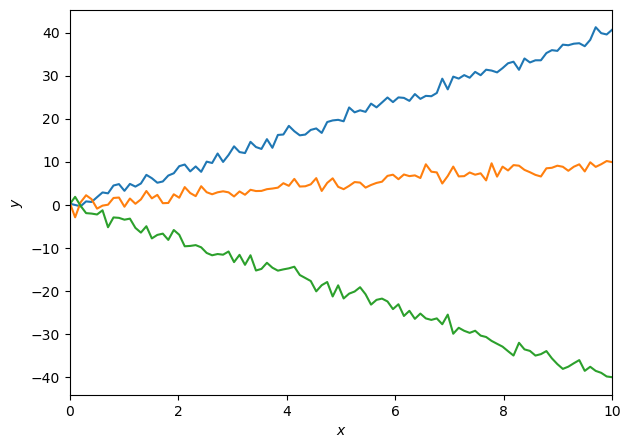

In [19]:
fig = plt.figure(figsize=(7, 5))
plt.xlabel("$x$")
plt.xlim([0, 10])
plt.ylabel("$y$");
plt.tick_params(axis="both")
plt.plot(x, target_data.T);

If we just look at the estimated target values we can see that both networks do well close to the fiducial parameter values, but the IMNN does badly far from the fiducial

In [20]:
print(f"IMNN parameter estimates = {IMNN.get_estimate(target_data)}")
print(f"regression parameter estimates = {model[1](w, target_data)}")

IMNN parameter estimates = [[ 4.0076017 ]
 [ 0.98308444]
 [-1.2913814 ]]
regression parameter estimates = [[ 4.025133 ]
 [ 0.9330112]
 [-4.225827 ]]


However, if we do the LFI, i.e. just run an ABC to get 1000 samples within an epsilon ball of $\epsilon=0.1$ we can compare the approximate posteriors. Note this epsilon doesn't mean the same thing for the two different estimators so choosing the same value doesn't really indicate how "marginal" the slice through the joint distribution of summaries and parameters is - for this reason we'll show the whole joint space.

In [21]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=target_data,
    prior=prior,
    simulator=partial(simulator, squeeze=False),
    compressor=IMNN.get_estimate,
    F=np.stack([IMNN.F for i in range(3)], axis=0))
mse_ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=target_data,
    prior=prior,
    simulator=partial(simulator, squeeze=False),
    compressor=lambda y: model[1](w, y))

In [22]:
rng, key = jax.random.split(rng)
ABC(rng=key, ϵ=0.1, n_samples=100000, min_accepted=1000, max_iterations=1000);
mse_ABC(rng=key, ϵ=0.1, n_samples=100000, min_accepted=1000, max_iterations=1000);

[1011 1042 3246] accepted in last  29 iterations  (2900000 simulations done).
[1942 1995 2110] accepted in last  1 iterations  (100000 simulations done).


And now we'll plot the joint space for all of the targets. The top subplot shows the a histogram of the parameter values used to generate simulations whose summaries are closest to the summaries of the target data, i.e. the approximate posterior. The bottom scatter plot shows the joint space of parameters and summary values (parameter estimates) and the bottom right subplot shows the likelihood of the summary values, i.e. the probability of values of the summaries at a given value of the target parameters.

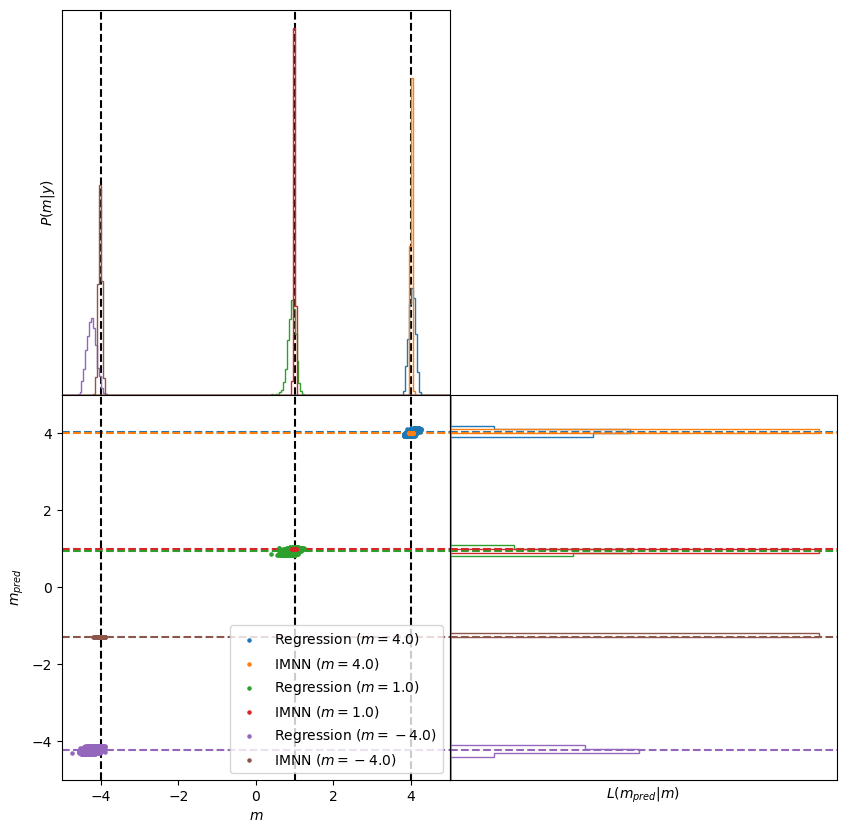

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(3):
    ax[0, 0].axvline(
        target_m[i], 
        color="black", 
        linestyle="dashed", 
        zorder=-1)
    ax[0, 0].hist(
        mse_ABC.parameters.accepted[i].T, 
        range=[-5., 5.], 
        bins=200, 
        histtype="step", 
        density=True)
    ax[0, 0].hist(
        ABC.parameters.accepted[i].T, 
        range=[-5., 5.], 
        bins=200, 
        histtype="step", 
        density=True)
    ax[1, 0].axhline(
        mse_ABC.target_summaries[i], 
        linestyle="dashed",
        color=f"C{i * 2}",
        zorder=-1)
    ax[1, 0].axhline(
        ABC.target_summaries[i], 
        linestyle="dashed",
        color=f"C{i * 2 + 1}",
        zorder=-1)
    ax[1, 0].axvline(
        target_m[i], 
        color="black", 
        linestyle="dashed",
        zorder=-1)
    ax[1, 0].scatter(
        mse_ABC.parameters.accepted[i], 
        mse_ABC.summaries.accepted[i], 
        s=5,
        label=f"Regression ($m = {target_m[i][0]}$)")
    ax[1, 0].scatter(
        ABC.parameters.accepted[i], 
        ABC.summaries.accepted[i], 
        s=5,
        label=f"IMNN ($m = {target_m[i][0]}$)")
    ax[1, 1].axhline(
        mse_ABC.target_summaries[i], 
        linestyle="dashed",
        color=f"C{i * 2}",
        zorder=-1)
    ax[1, 1].axhline(
        ABC.target_summaries[i], 
        linestyle="dashed",
        color=f"C{i * 2 + 1}",
        zorder=-1)
    ax[1, 1].hist(
        mse_ABC.summaries.accepted[i].T, 
        range=[-5., 5.], 
        bins=100, 
        histtype="step", 
        density=True, 
        orientation="horizontal")
    ax[1, 1].hist(
        ABC.summaries.accepted[i].T, 
        range=[-5., 5.], 
        bins=100, 
        histtype="step", 
        density=True, 
        orientation="horizontal")

ax[1, 0].legend(loc=4)
ax[0, 1].axis("off")
ax[0, 0].set(
    xticks=[],
    yticks=[],
    xlim=(-5, 5),
    ylabel="$P(m|y)$")
ax[1, 0].set(
    xlabel="$m$",
    ylabel="$m_{pred}$",
    xlim=(-5, 5),
    ylim=(-5, 5))
ax[1, 1].set(
    xticks=[],
    yticks=[],
    ylim=(-5, 5),
    xlabel="$L(m_{pred}|m)$");

Here we can see that the IMNN has consistently tighter posteriors (top subplot) than the regression network, and seemingly less bias (looking at the green constraints from the regression network and the red constraints from the INMN). Here, clearly the size of the epsilon is apparently accepting summaries from further away for the regression network, but even just looking (again the green) scatter points, the bulk of the scatter points at the horizontal green line is further from the black dashed vertical line showing that more samples would be needed inside a smaller epsilon ball which would likely lead to a wide posterior anyway.

Cool hey!